To-Do:
- develop an autocomplete API that allows users to pick findings in the HPO database
- find groups of findings that add up to effectively pathognominic

## Given a set of findings, return the most likely rare diseases

Number of diseases imported from the ORDO database: 10,735  
Number of phenotypes imported from the HPO database: 10,653  
Number of disease-phenotype relations imported from the HOOM database: 108,638  

In [1]:
import getpass
import pandas as pd
password = getpass.getpass("\nPlease enter the Neo4j database password to continue \n")

from neo4j import GraphDatabase
driver=GraphDatabase.driver(uri="bolt://localhost:7687", auth=('neo4j',password))
session=driver.session()


Please enter the Neo4j database password to continue 
 ············


In [25]:
# Get a count of the number of rare diseases associated with each human phenotype entity, 
# and set that number as a property of the human phenotype entity
query = '''
MATCH (h:HPOentity)-[:ASSOC_WITH]-(o:OrphEntity)
WITH h, count(o) as Number
SET h.number_assoc_rare_diseases = Number
RETURN h.name, h.number_assoc_rare_diseases AS freq
ORDER BY freq DESC
'''
data = session.run(query)
hpo_frequencies = pd.DataFrame([dict(record) for record in data])

hpo_frequencies

,h.name,freq
0,Seizure,1024
1,Intellectual disability,862
2,Short stature,783
3,Global developmental delay,736
4,Microcephaly,590
...,...,...
6711,Abnormal molar morphology,1
6712,Abnormality of permanent molar morphology,1
6713,Localized hypoplasia of dental enamel,1
6714,Hypomature dental enamel,1


<AxesSubplot:>

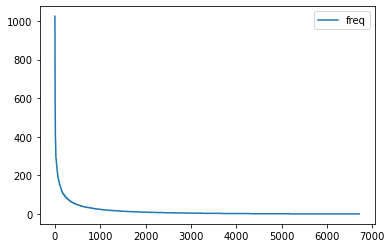

In [44]:
hpo_frequencies.plot()

In [30]:
# Get the maximum and minimum estimated prevalence values for each disease
# and set these as upper and lower estimate properties on each disease
query = '''
MATCH (n:OrphEntity)
UNWIND [n.point_prevalence, n.birth_prevalence, n.lifetime_prevalence] AS prev
WITH max(prev) AS max_prev, min(prev) AS min_prev, n
SET n.prevalence_estimate_upper = max_prev, n.prevalence_estimate_lower = min_prev
RETURN n.name, n.prevalence_estimate_upper, n.prevalence_estimate_lower
'''
data = session.run(query)
disease_prevalences = pd.DataFrame([dict(record) for record in data])
disease_prevalences

,n.name,n.prevalence_estimate_upper,n.prevalence_estimate_lower
0,"48,XXYY syndrome",0.000050,0.000050
1,Ataxia-telangiectasia,0.000175,0.000028
2,Ocular albinism with late-onset sensorineural ...,0.000001,0.000001
3,Reticular perineurioma,NaN,NaN
4,Sclerosing perineurioma,NaN,NaN
...,...,...,...
10730,Intermediate DEND syndrome,NaN,NaN
10731,Brill-Zinsser disease,NaN,NaN
10732,Relapsing epidemic typhus,NaN,NaN
10733,Complex regional pain syndrome type 2,NaN,NaN


In [32]:
# Find the number of phenotype relations which constitute diagnostic criteria
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
RETURN r.diagnostic_criterion_attribute, count(r)
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,r.diagnostic_criterion_attribute,count(r)
0,None,107457
1,Exclusion_DC,633
2,Criterion_DC,541
3,Pathognomomic_DC,7


In [43]:
# Find the number of diseases with at least one diagnostic criterion
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
RETURN r.diagnostic_criterion_attribute, count(distinct(o))
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,r.diagnostic_criterion_attribute,count(distinct(o))
0,None,4342
1,Exclusion_DC,319
2,Criterion_DC,170
3,Pathognomomic_DC,7


In [39]:
# Examine the pathognomonic findings and their corresponding diseases
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
WHERE r.diagnostic_criterion_attribute = 'Pathognomomic_DC'
RETURN n.name AS Finding, o.name AS Disease
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,Finding,Disease
0,Ovarian gonadoblastoma,Gonadoblastoma
1,Ganglioneuroma,Ganglioneuroma
2,Remnants of the hyaloid vascular system,Persistent hyperplastic primary vitreous
3,Adrenocortical cytomegaly,Beckwith-Wiedemann syndrome
4,True hermaphroditism,"46,XY ovotesticular disorder of sex development"
5,Pituitary carcinoma,Pituitary carcinoma
6,Recurrent singultus,Chronic hiccup


Of the pathognomonic findings above, only adrenocortical cytomegaly may provide a non-obvious diagnosis. Looks like using pathognomonic findings from this dataset won't be much help in identifying kids with rare disease. Let's see where a more probabilistic approach takes us.

## Challenges

Given the findings associated with a single disease, identify which disease is the most likely diagnosis.  
Given the findings for two diseases mixed up in a single list, identify which two diseases are the most likely and which of the findings go with each disease.  
Given the findings for n diseases, find the minimum set of diseases which can account for the maximum number of findings.  
Can we find a kid with Alstrom syndrome based on these findings: Dilated cardiomypathy, obesity, visual abnormality, +/- diabetes

Factors which increase the likelihood of a disease:
- the number of findings in the given list which match to a disease
- a higher prevalence of the disease in the general population

Factors which decrease the likelihood of a disease:
- findings in a given list which have "Exclusion_DC" in their connection to a disease
- the absence of findings which have a high approx_frequency of association between the finding and a disease

Factors which increase the weight of any given finding:
- a higher specificity of a given finding for a disease
- presence of the "Criterion_DC" or "Pathognomomic_DC" in their connection to a disease

## Approach
1. Get a list of diseases which have at least one finding in the list of given findings, and which are not excluded by the given findings
2. Calculate the likelihood of each disease:  
Likelihood of disease = (disease prevalence) X (specificity of present finding 1 + ...specificity of present finding n) X (number of "Criterion_DC" findings) / (approx_frequency of absent finding 1 + ...approx_frequency of absent finding n)  
-or-  
Likelihood of disease = (disease prevalence) X (number of findings positive in this patient) / (total number findings associated with the disease)  
3. Sort the list from most likely to least

In [7]:
# Get lists of findings associated with a couple of diseases
query = '''
MATCH (h:HPOentity)-[r:ASSOC_WITH]->(d:OrphEntity)
WHERE d.umls_id IN ["C2930971", "C0018854", "C1969443"]
RETURN d.name AS Disease, collect(h.name) as Findings'''
data = session.run(query)
disease_example = pd.DataFrame([dict(record) for record in data])
disease_example

,Disease,Findings
0,Gamma-heavy chain disease,"[Peripheral neuropathy, Recurrent respiratory ..."
1,Long chain 3-hydroxyacyl-CoA dehydrogenase def...,"[Peripheral neuropathy, Abnormality of metabol..."
2,Mitochondrial trifunctional protein deficiency,"[Generalized muscle weakness, Lethargy, Left v..."
3,Hajdu-Cheney syndrome,"[Peripheral neuropathy, Chiari malformation, T..."


In [6]:
dz_1_findings = disease_example['Findings'][0]
dz_2_findings = disease_example['Findings'][1]
dz_3_findings = disease_example['Findings'][2]
dz_4_findings = disease_example['Findings'][3]
dz_1_2_findings = list(set(dz_1_findings + dz_2_findings))

dz_1_findings

['C0442874',
 'C3806482',
 'C0015967',
 'C0015672',
 'C0427546',
 'C4021815',
 'C0011168',
 'C0038002',
 'C0497156',
 'C0004364',
 'C0019209',
 'C0003873',
 'C0162119',
 'C0015230',
 'C0392386',
 'C4021634',
 'C0002880',
 'C0920163',
 'C0221204',
 'C0040411']

In [9]:
# Get a list of diseases which have at least one finding in the list of given findings,
# and which are not excluded by the given findings
query = '''
MATCH (given_f:HPOentity)-[r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[:ASSOC_WITH]->(d)
WHERE given_f.umls_id IN {finding_list} AND (r.diagnostic_criterion_attribute IS NULL OR NOT r.diagnostic_criterion_attribute = 'Exclusion_DC')
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, toFloat(SIZE(collect(DISTINCT(given_f.name)))) AS Ct_Positive_Findings, collect(DISTINCT(given_f.name)) AS Positive_Findings, toFloat(SIZE(collect(DISTINCT(total_f.name)))) AS Ct_All_Dz_Findings, collect(DISTINCT(total_f.name)) AS All_Dz_Findings
WITH Disease, Dz_Prevalence, (Ct_Positive_Findings/Ct_All_Dz_Findings) AS Proportion_of_Findings, Positive_Findings, All_Dz_Findings
RETURN Disease, Dz_Prevalence, Proportion_of_Findings, Positive_Findings, All_Dz_Findings
ORDER BY Proportion_of_Findings DESC
'''.format(finding_list = dz_1_findings)
# print(query)
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Dz_Prevalence'])

,Disease,Dz_Prevalence,Proportion_of_Findings,Positive_Findings,All_Dz_Findings
0,Gamma-heavy chain disease,0.000001,1.000000,"[Abnormal palate morphology, Skin rash, Rheuma...","[Abnormal palate morphology, Skin rash, Rheuma..."
1,Mendelian susceptibility to mycobacterial dise...,0.000001,0.666667,"[Fever, Lymphadenopathy]","[Fever, Lymphadenopathy, Abnormality of immune..."
2,Mu-heavy chain disease,0.000001,0.583333,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Splenomegaly, Weig..."
3,Mantle cell lymphoma,0.000050,0.555556,"[Splenomegaly, Fever, Lymphadenopathy, Abnorma...","[Splenomegaly, Weight loss, Fever, Anorexia, L..."
7,Klatskin tumor,0.000050,0.444444,"[Fever, Hepatomegaly, Lymphadenopathy, Fatigue]","[Jaundice, Weight loss, Fever, Abdominal pain,..."
...,...,...,...,...,...
1408,Koolen-De Vries syndrome due to a point mutation,0.000001,0.008197,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch..."
1409,17q21.31 microdeletion syndrome,0.000050,0.008197,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch..."
1410,Wiedemann-Rautenstrauch syndrome,0.000001,0.008000,[Fever],"[Recurrent urinary tract infections, Cryptorch..."
1411,Mowat-Wilson syndrome,0.000050,0.007576,[Dysphagia],"[Multicystic kidney dysplasia, Urinary inconti..."


In [12]:
query = '''
MATCH (given_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[total_r:ASSOC_WITH]->(d)
WHERE given_f.umls_id IN ['C0442874',
 'C3806482',
 'C0015967',
 'C0015672',
 'C0427546',
 'C4021815',
 'C0011168',
 'C0038002',
 'C0497156',
 'C0004364',
 'C0019209',
 'C0003873',
 'C0162119',
 'C0015230',
 'C0392386',
 'C4021634',
 'C0002880',
 'C0920163',
 'C0221204',
 'C0040411'] AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

// Collect a list of the negative findings for each disease
WITH collect(total_r) AS total_r_list, COLLECT(given_r) AS given_r_list, total_f, given_f, d
WITH [x IN total_r_list WHERE not x in given_r_list] AS neg_finding_list, total_f, given_f, d
UNWIND neg_finding_list AS neg_findings

// Count and collect into a list the positive findings for each disease and all the potential findings for each disease
// Take the average of the approximate frequency values for all negative findings for each disease
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, toFloat(SIZE(collect(DISTINCT(given_f.name)))) AS Ct_Positive_Findings, collect(DISTINCT(given_f.name)) AS Positive_Findings, toFloat(SIZE(collect(DISTINCT(total_f.name)))) AS Ct_All_Dz_Findings, collect(DISTINCT(total_f.name)) AS All_Dz_Findings, avg(toFloat(neg_findings.approx_frequency)) AS Avg_Neg_Find_Freq

// Calculate the proportion of positive findings among all the potential findings for each disease
// Calculate the number of negative findings for each disease
WITH Disease, Dz_Prevalence, (Ct_Positive_Findings/Ct_All_Dz_Findings) AS Proportion_of_Findings, (Ct_All_Dz_Findings - Ct_Positive_Findings) AS Ct_Neg_Findings, Positive_Findings, All_Dz_Findings, Avg_Neg_Find_Freq

// Multiply the average frequency value for all negative findings for each disease by the number of negative findings for the disease
WITH (Avg_Neg_Find_Freq * Ct_Neg_Findings) AS Neg_Findings_Weight, Disease, Dz_Prevalence, Proportion_of_Findings, Positive_Findings, All_Dz_Findings

// Normalize the negative findings weight to values ranging from 0 to 1

RETURN Neg_Findings_Weight, Disease, Dz_Prevalence, Proportion_of_Findings, Positive_Findings, All_Dz_Findings
ORDER BY Dz_Prevalence, Proportion_of_Findings  DESC
'''
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Dz_Prevalence'])

,Neg_Findings_Weight,Disease,Dz_Prevalence,Proportion_of_Findings,Positive_Findings,All_Dz_Findings
0,0.000000,Gamma-heavy chain disease,0.000001,1.000000,"[Skin rash, Rheumatoid arthritis, Splenomegaly...","[Abnormal palate morphology, Skin rash, Rheuma..."
1,0.895000,Mendelian susceptibility to mycobacterial dise...,0.000001,0.666667,"[Lymphadenopathy, Fever]","[Fever, Lymphadenopathy, Abnormality of immune..."
2,2.828896,Mu-heavy chain disease,0.000001,0.583333,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Splenomegaly, Weig..."
3,8.770937,Schnitzler syndrome,0.000001,0.380952,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Skin rash, Pruritus, Urticaria, Arthritis, Sp..."
4,1.885714,Fish-eye disease,0.000001,0.375000,"[Splenomegaly, Hepatomegaly, Lymphadenopathy]","[Visual impairment, Angina pectoris, Splenomeg..."
...,...,...,...,...,...,...
890,14.989149,Ectodermal dysplasia syndrome,0.000750,0.021277,[Dysphagia],"[Abnormality of the dentition, Oral cleft, Xer..."
891,35.559074,Noonan syndrome,0.000750,0.018519,[Hepatomegaly],"[Cryptorchidism, Hypogonadotropic hypogonadism..."
892,15.054077,Primary Sjögren syndrome,0.000762,0.060606,"[Thrombocytopenia, Lymphadenopathy, Peripheral...","[Abnormality of the kidney, Renal insufficienc..."
893,14.427708,Amish lethal microcephaly,0.001000,0.041667,[Hepatomegaly],"[Cleft soft palate, Microcephaly, Sloping fore..."


In [22]:
query = '''
WITH ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411'] AS all_given_findings
MATCH (given_f:HPOentity)
WHERE given_f.umls_id IN all_given_findings
WITH collect(given_f) AS given_f_list

MATCH (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[total_r:ASSOC_WITH]->(d)
WHERE pos_f IN given_f_list AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

// Get lists of positive findings and relationships to positive findings
// Get lists of negative findings and relationships to negative findings
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(given_r)) AS Pos_Find_Rel, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings, given_f_list
WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, given_f_list, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel
WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, Neg_Find_Rel, Pos_Find_Rel, given_f_list, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel
UNWIND Pos_Find_Rel AS Pos_Find_Rel_List
UNWIND Neg_Find_Rel AS Neg_Find_Rel_List
UNWIND given_f_list AS given_f
UNWIND All_Find_Rel AS All_Find_Rel_List

// Get lists of negative findings and relationships to negative findings
WITH collect(Neg_Find_Rel_List.approx_frequency) AS Neg_Find_Freq, Disease, given_f, all_dz_findings, Dz_Prevalence, Pos_Find_Rel_List, All_Find_Rel_List, Positive_Findings, Negative_Findings

WITH Disease, collect(DISTINCT(given_f.name)) AS all_given_findings, all_dz_findings, Dz_Prevalence, Pos_Find_Rel_List, All_Find_Rel_List, Positive_Findings, Negative_Findings

WITH Disease, all_given_findings, all_dz_findings, Dz_Prevalence, collect(Pos_Find_Rel_List.approx_frequency) AS Pos_Find_Freq, All_Find_Rel_List, Positive_Findings, Negative_Findings

RETURN Disease, all_given_findings, all_dz_findings, Dz_Prevalence, Pos_Find_Freq, collect(All_Find_Rel_List.approx_frequency) AS All_Find_Freq, Positive_Findings, Negative_Findings

LIMIT 10
'''
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Dz_Prevalence'])

,Disease,all_given_findings,all_dz_findings,Dz_Prevalence,Pos_Find_Freq,All_Find_Freq,Positive_Findings,Negative_Findings
0,Zellweger syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Cryptorchidism,...",0.000050,[0.895],"[0.545, 0.545, 0.545, 0.545, 0.17, 0.545, 0.54...",[Hepatomegaly],"[Multicystic kidney dysplasia, Cryptorchidism,..."
1,Microgastria-limb reduction defect syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Horseshoe kidne...",0.000001,[0.17],"[0.545, 0.17, 0.17, 0.545, 0.17, 0.17, 0.17, 0...",[Hepatomegaly],"[Multicystic kidney dysplasia, Horseshoe kidne..."
2,Prune belly syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Recurrent urina...",0.000028,[0.545],"[0.545, 0.545, 0.895, 0.895, 0.895, 0.895, 0.8...",[Recurrent respiratory infections],"[Multicystic kidney dysplasia, Recurrent urina..."
3,Cornelia de Lange syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Cryptorchidism,...",0.000028,[0.17],"[0.545, 0.545, 0.545, 0.545, 0.545, 0.17, 0.17...",[Peripheral neuropathy],"[Multicystic kidney dysplasia, Cryptorchidism,..."
5,Autosomal recessive Robinow syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Inguinal hernia...",0.000001,"[0.17, 0.17]","[0.17, 0.17, 0.545, 0.17, 0.895, 0.895, 0.17, ...","[Abnormal palate morphology, Recurrent respira...","[Multicystic kidney dysplasia, Inguinal hernia..."
6,"Campomelia, Cumming type","[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Cleft palate, D...",0.000001,[0.545],"[0.895, 0.895, 0.895, 0.17, 0.895, 0.545, 0.89...",[Hepatomegaly],"[Multicystic kidney dysplasia, Cleft palate, D..."
7,Mowat-Wilson syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Urinary inconti...",0.000050,[0.025],"[0.17, 0.545, 0.545, 0.025, 0.025, 0.545, 0.02...",[Dysphagia],"[Multicystic kidney dysplasia, Urinary inconti..."
8,Jacobsen syndrome,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Inguinal hernia...",0.000050,"[0.17, 0.895, 0.545]","[0.17, 0.17, 0.545, 0.17, 0.17, 0.17, 0.545, 0...","[Abnormal palate morphology, Thrombocytopenia,...","[Multicystic kidney dysplasia, Inguinal hernia..."
9,Radioulnar synostosis-developmental delay-hypo...,"[Abnormal palate morphology, Skin rash, Rheuma...","[Multicystic kidney dysplasia, Abnormality of ...",0.000001,[0.895],"[0.545, 0.545, 0.895, 0.895, 0.895, 0.895, 0.8...",[Abnormal palate morphology],"[Multicystic kidney dysplasia, Abnormality of ..."


In [31]:
# Pull relevant info for an example disease
query = '''
MATCH (h:HPOentity)-[r:ASSOC_WITH]->(n:OrphEntity {umls_id:'C0018854'}) 
RETURN n.name AS Disease, n.prevalence_estimate_upper AS Dz_Prevalence, h.name AS Finding, h.number_assoc_rare_diseases AS Number_Assoc_Rare_Diseases, r.approx_frequency AS Approximate_Freq_Finding_Dz_Association'''
data = session.run(query)
disease_example = pd.DataFrame([dict(record) for record in data])
disease_example

,Disease,Dz_Prevalence,Finding,Number_Assoc_Rare_Diseases,Approximate_Freq_Finding_Dz_Association
0,Gamma-heavy chain disease,0.000001,Peripheral neuropathy,167,0.17
1,Gamma-heavy chain disease,0.000001,Recurrent respiratory infections,180,0.17
2,Gamma-heavy chain disease,0.000001,Fever,286,0.895
3,Gamma-heavy chain disease,0.000001,Fatigue,284,0.895
4,Gamma-heavy chain disease,0.000001,Abnormal lymphocyte morphology,9,0.895
5,Gamma-heavy chain disease,0.000001,Abnormal palate morphology,69,0.17
6,Gamma-heavy chain disease,0.000001,Dysphagia,265,0.17
7,Gamma-heavy chain disease,0.000001,Splenomegaly,213,0.545
8,Gamma-heavy chain disease,0.000001,Lymphadenopathy,125,0.545
9,Gamma-heavy chain disease,0.000001,Autoimmunity,120,0.17


In [26]:
query = '''
WITH ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411'] AS all_given_findings
MATCH (given_f:HPOentity)
WHERE given_f.umls_id IN all_given_findings
WITH collect(given_f) AS given_f_list

MATCH (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[total_r:ASSOC_WITH]->(d)
WHERE pos_f IN given_f_list AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

// Get lists of positive findings and relationships to positive findings
// Get lists of negative findings and relationships to negative findings
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(given_r)) AS Pos_Find_Rel, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings, given_f_list
WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, given_f_list, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel
WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, Neg_Find_Rel, Pos_Find_Rel, given_f_list, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel
UNWIND Pos_Find_Rel AS Pos_Find_Rel_List
UNWIND Neg_Find_Rel AS Neg_Find_Rel_List
UNWIND given_f_list AS given_f

// Get lists of negative findings and relationships to negative findings
WITH sum(toFloat(Neg_Find_Rel_List.approx_frequency)) AS Neg_Find_Freq, Disease, given_f, all_dz_findings, Dz_Prevalence, Pos_Find_Rel_List, Positive_Findings, Negative_Findings

WITH Disease, collect(DISTINCT(given_f.name)) AS all_given_findings, all_dz_findings, Dz_Prevalence, Pos_Find_Rel_List, Positive_Findings, Negative_Findings, Neg_Find_Freq

WITH Disease, all_given_findings, all_dz_findings, Dz_Prevalence, sum(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Pos_Find_Freq, Positive_Findings, Negative_Findings, Neg_Find_Freq

RETURN Disease, size(all_given_findings), size(all_dz_findings), size(Positive_Findings), Dz_Prevalence, Pos_Find_Freq, Neg_Find_Freq, Positive_Findings, Negative_Findings, (Dz_Prevalence * (toFloat(size(Positive_Findings)) / toFloat(size(all_given_findings))) * (Pos_Find_Freq - Neg_Find_Freq) / toFloat(size(all_dz_findings)) ) AS score

ORDER BY score DESC
'''
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Dz_Prevalence'])

,Disease,size(all_given_findings),size(all_dz_findings),size(Positive_Findings),Dz_Prevalence,Pos_Find_Freq,Neg_Find_Freq,Positive_Findings,Negative_Findings,score
519,Mantle cell lymphoma,20,9,5,0.000050,3.075,2.155,"[Splenomegaly, Fever, Lymphadenopathy, Abnorma...","[Weight loss, Anorexia, Abnormality of the gas...",1.277778e-06
520,Mu-heavy chain disease,20,12,7,0.000001,4.140,2.675,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Weight loss, Incre...",4.272917e-08
521,Mendelian susceptibility to mycobacterial dise...,20,3,2,0.000001,1.790,0.895,"[Fever, Lymphadenopathy]",[Abnormality of immune system physiology],2.983333e-08
522,Congenital atransferrinemia,20,6,1,0.000001,0.895,1.225,[Anemia],"[Hypothyroidism, Arthritis, Abnormality of the...",-2.750000e-09
523,"Late-onset distal myopathy, Markesbery-Griggs ...",20,19,1,0.000001,0.025,2.020,[Peripheral neuropathy],"[Gait disturbance, Abnormality of the cardiova...",-5.250000e-09
...,...,...,...,...,...,...,...,...,...,...
1408,Primary Sjögren syndrome,20,66,4,0.000762,0.910,15.100,"[Thrombocytopenia, Lymphadenopathy, Peripheral...","[Abnormality of the kidney, Renal insufficienc...",-3.278750e-05
1409,Familial Mediterranean fever,20,37,4,0.000551,1.405,12.610,"[Skin rash, Splenomegaly, Fever, Lymphadenopathy]","[Proteinuria, Nephrotic syndrome, Nephropathy,...",-3.335002e-05
1410,Behçet disease,20,68,4,0.000551,2.130,23.705,"[Splenomegaly, Fever, Lymphadenopathy, Fatigue]","[Renal insufficiency, Oral ulcer, Retinopathy,...",-3.494040e-05
1411,Sarcoidosis,20,72,7,0.000713,2.315,16.035,"[Thrombocytopenia, Anemia, Fever, Hepatomegaly...","[Renal insufficiency, Nephrocalcinosis, Abnorm...",-4.754063e-05


In [67]:
query = '''
WITH ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411'] AS all_given_findings

MATCH (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[total_r:ASSOC_WITH]->(d)
WHERE pos_f.umls_id IN all_given_findings AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

// Get lists of positive findings and relationships to positive findings
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(given_r)) AS Pos_Find_Rel, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings

// Get list of relationships to negative findings
WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel

// Get list of negative findings
WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, Neg_Find_Rel, Pos_Find_Rel, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel
UNWIND Pos_Find_Rel AS Pos_Find_Rel_List
UNWIND Neg_Find_Rel AS Neg_Find_Rel_List

// Get averge approximate frequency for negative findings
WITH avg(toFloat(Neg_Find_Rel_List.approx_frequency)) AS Neg_Find_Freq, Disease, all_dz_findings, Dz_Prevalence, Pos_Find_Rel_List, Positive_Findings, Negative_Findings

// Get averge approximate frequency for positive findings
WITH Disease, all_dz_findings, Dz_Prevalence, sum(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Pos_Find_Freq, Positive_Findings, Negative_Findings, Neg_Find_Freq

RETURN Disease, size(all_dz_findings), size(Positive_Findings), log10(Dz_Prevalence) AS Log_Prevalence, Pos_Find_Freq, Neg_Find_Freq, Positive_Findings, Negative_Findings, (toFloat(size(Positive_Findings)) / toFloat(size(all_dz_findings))) AS score

ORDER BY score DESC
'''
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Log_Prevalence'])

,Disease,size(all_dz_findings),size(Positive_Findings),Log_Prevalence,Pos_Find_Freq,Neg_Find_Freq,Positive_Findings,Negative_Findings,score
0,Mendelian susceptibility to mycobacterial dise...,3,2,-6.000000,1.790,0.895000,"[Fever, Lymphadenopathy]",[Abnormality of immune system physiology],0.666667
1,Mu-heavy chain disease,12,7,-6.000000,4.140,0.535000,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Weight loss, Incre...",0.583333
2,Mantle cell lymphoma,9,5,-4.301030,3.075,0.538750,"[Splenomegaly, Fever, Lymphadenopathy, Abnorma...","[Weight loss, Anorexia, Abnormality of the gas...",0.555556
6,Klatskin tumor,9,4,-4.301030,1.430,0.460000,"[Fever, Hepatomegaly, Lymphadenopathy, Fatigue]","[Jaundice, Weight loss, Abdominal pain, Venous...",0.444444
9,Fetal cytomegalovirus syndrome,7,3,-3.522879,1.635,0.807500,"[Splenomegaly, Anemia, Hepatomegaly]","[Sensorineural hearing impairment, Abnormality...",0.428571
...,...,...,...,...,...,...,...,...,...
1407,Koolen-De Vries syndrome due to a point mutation,122,1,-6.000000,0.170,0.328719,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch...",0.008197
1408,17q21.31 microdeletion syndrome,122,1,-4.301030,0.170,0.328719,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch...",0.008197
1409,Wiedemann-Rautenstrauch syndrome,125,1,-6.000000,0.545,0.531532,[Fever],"[Recurrent urinary tract infections, Cryptorch...",0.008000
1410,Mowat-Wilson syndrome,132,1,-4.301030,0.025,0.324504,[Dysphagia],"[Multicystic kidney dysplasia, Urinary inconti...",0.007576


In [63]:
disease_1_search[disease_1_search['Disease'] == 'Mu-heavy chain disease']

,Disease,size(all_dz_findings),size(Positive_Findings),Log_Prevalence,Pos_Find_Freq,Neg_Find_Freq,Positive_Findings,Negative_Findings,score
1,Mu-heavy chain disease,12,7,-6.0,4.14,0.535,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Weight loss, Incre...",0.583333


In [64]:
disease_1_search[disease_1_search['Disease'] == 'Gamma-heavy chain disease']

,Disease,size(all_dz_findings),size(Positive_Findings),Log_Prevalence,Pos_Find_Freq,Neg_Find_Freq,Positive_Findings,Negative_Findings,score


In [ ]:
(0.0001*log10(Dz_Prevalence) + (toFloat(size(Positive_Findings)) / toFloat(size(all_dz_findings))) - (Neg_Find_Freq*toFloat(size(Negative_Findings))) )

In [170]:
# Get a list of diseases which have at least one finding in the list of given findings,
# and which are not excluded by the given findings
query = '''
WITH ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411'] AS all_given_findings

MATCH (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity)<-[total_r:ASSOC_WITH]-(total_f:HPOentity)
//MATCH (total_f:HPOentity)-[total_r:ASSOC_WITH]->(d)
WHERE pos_f.umls_id IN all_given_findings AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

// Get lists of positive findings and relationships to positive findings
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings, collect(DISTINCT(given_r)) AS Pos_Find_Rel

// Get list of approx frequencies for positive findings
// WITH collect(given_r.approx_frequency) AS Pos_Find_Rel, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings, All_Find_Rel

// Get list of relationships to negative findings
WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings

// Get list of negative findings
WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, Neg_Find_Rel, Pos_Find_Rel, Disease, all_dz_findings, Dz_Prevalence, Positive_Findings

// Calculate the proportion of findings for each disease which are positive
WITH Disease, Dz_Prevalence, (toFloat(SIZE(Positive_Findings))/toFloat(SIZE(all_dz_findings))) AS Proportion_of_Findings, Positive_Findings, Negative_Findings, all_dz_findings, Pos_Find_Rel, Neg_Find_Rel

UNWIND Pos_Find_Rel as Pos_Find_Rel_List

UNWIND
  CASE
    WHEN Neg_Find_Rel = [] THEN [null]
    ELSE Neg_Find_Rel
  END AS Neg_Find_Rel_List

// Calculate the mean approximate frequency and count of all negative findings for each disease, changing null to 0 when no relationships to negative findings exist
WITH Disease, Dz_Prevalence, Proportion_of_Findings, Positive_Findings, Negative_Findings, Pos_Find_Rel_List, avg(toFloat(COALESCE(Neg_Find_Rel_List.approx_frequency, 0))) AS Avg_Neg_Find_Freq, toFloat(SIZE(Negative_Findings)) AS Ct_Neg_Findings

// Calculate the mean approximate frequency and count of all positive findings for each disease
WITH Disease, Dz_Prevalence, Proportion_of_Findings, Positive_Findings, Negative_Findings, avg(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Ct_Neg_Findings, toFloat(SIZE(Positive_Findings)) AS Ct_Pos_Findings

// Calculate the mean frequency of findings, weighted by the count of findings, for both positive and negative findings
WITH Disease, Dz_Prevalence, Ct_Neg_Findings, Ct_Pos_Findings, Proportion_of_Findings, Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Positive_Findings, Negative_Findings, (Avg_Pos_Find_Freq * Ct_Pos_Findings) AS Wghtd_Avg_Pos_Findings, (Avg_Neg_Find_Freq * Ct_Neg_Findings) AS Wghtd_Avg_Neg_Findings

// Calculate the difference between the weighted mean frequencies of positive and negative findings
WITH Disease, Dz_Prevalence, Ct_Neg_Findings, Ct_Pos_Findings, Proportion_of_Findings, Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Positive_Findings, Negative_Findings, (Wghtd_Avg_Pos_Findings - Wghtd_Avg_Neg_Findings) AS Wghtd_Avg_Diff

// Multiply the disease prevalence by the difference between the weighted mean frequencies of positive and negative findings
RETURN Disease, Dz_Prevalence, Ct_Neg_Findings, Ct_Pos_Findings, Proportion_of_Findings, Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Positive_Findings, Negative_Findings, (Wghtd_Avg_Diff * -log10(Dz_Prevalence)) AS Probability

ORDER BY Probability DESC
'''.format(finding_list = dz_1_findings)
# print(query)
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Dz_Prevalence'])

,Disease,Dz_Prevalence,Ct_Neg_Findings,Ct_Pos_Findings,Proportion_of_Findings,Avg_Pos_Find_Freq,Avg_Neg_Find_Freq,Positive_Findings,Negative_Findings,Probability
519,Gamma-heavy chain disease,0.000001,0.0,20.0,1.000000,0.427500,0.000000,"[Abnormal palate morphology, Skin rash, Rheuma...",[],51.300000
520,Mu-heavy chain disease,0.000001,5.0,7.0,0.583333,0.591429,0.535000,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Increased circulating antibody l...",8.790000
521,Mendelian susceptibility to mycobacterial dise...,0.000001,1.0,2.0,0.666667,0.895000,0.895000,"[Fever, Lymphadenopathy]",[Abnormality of immune system physiology],5.370000
522,Mantle cell lymphoma,0.000050,4.0,5.0,0.555556,0.615000,0.538750,"[Splenomegaly, Fever, Lymphadenopathy, Abnorma...","[Abnormality of the gastrointestinal tract, B-...",3.956948
523,Tuberculosis,0.000300,3.0,2.0,0.400000,0.545000,0.545000,"[Fever, Fatigue]","[Weight loss, Cough, Abnormal lung morphology]",-1.919969
...,...,...,...,...,...,...,...,...,...,...
1409,Pitt-Hopkins syndrome,0.000005,67.0,1.0,0.014925,0.895000,0.708955,[Abnormal palate morphology],"[Ataxia, Growth delay, Constipation, Intellect...",-247.054503
1410,Oculocerebrorenal syndrome of Lowe,0.000005,117.0,3.0,0.025000,0.295000,0.415299,"[Thrombocytopenia, Anemia, Recurrent respirato...","[Deep philtrum, Multiple renal cysts, Microgna...",-252.885636
1411,Orofaciodigital syndrome type 4,0.000001,66.0,1.0,0.015152,0.895000,0.683258,[Recurrent respiratory infections],"[Failure to thrive, Subcortical cerebral atrop...",-265.200000
1412,Williams syndrome,0.000175,186.0,1.0,0.005376,0.170000,0.467849,[Recurrent respiratory infections],"[Nevus flammeus, Cryptorchidism, Long philtrum...",-326.292145


In [96]:
disease_1_search[disease_1_search['Disease'] == 'Mu-heavy chain disease']

,Disease,Dz_Prevalence,Proportion_of_Findings,Positive_Findings,all_dz_findings,Pos_Find_Freq,Neg_Find_Rel
1,Mu-heavy chain disease,0.000001,0.583333,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Abnormality of bone marrow cell morphology, F...",0.591429,"[(approx_frequency, evidence), (approx_frequen..."


In [95]:
disease_1_search[disease_1_search['Disease'] == 'Gamma-heavy chain disease']

,Disease,Dz_Prevalence,Proportion_of_Findings,Positive_Findings,all_dz_findings,Pos_Find_Freq,Neg_Find_Rel


In [145]:
disease_1_search["all_dz_findings"][3]

['Abnormality of the gastrointestinal tract',
 'B-cell lymphoma',
 'Weight loss',
 'Fatigue',
 'Fever',
 'Lymphadenopathy',
 'Abnormality of bone marrow cell morphology',
 'Anorexia',
 'Splenomegaly']

In [146]:
disease_1_search["Positive_Findings"][3]

['Splenomegaly',
 'Fever',
 'Lymphadenopathy',
 'Abnormality of bone marrow cell morphology',
 'Fatigue']

In [147]:
disease_1_search["Negative_Findings"][3]

['Abnormality of the gastrointestinal tract',
 'B-cell lymphoma',
 'Weight loss',
 'Anorexia']